In [ ]:
! pip install -q kaggle

In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"nishanthardy","key":"f6bd6610310a710d2803039bd24af844"}'}

In [7]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
! cp kaggle.json ~/.kaggle/

In [9]:
! chmod 600 ~/.kaggle/kaggle.json

In [10]:
! kaggle datasets list

ref                                                             title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/most-streamed-spotify-songs-2024               Most Streamed Spotify Songs 2024                   496KB  2024-06-15 18:50:51           2885         73  1.0              
rabieelkharoua/students-performance-dataset                     📚 Students Performance Dataset 📚                    66KB  2024-06-12 23:09:20           3750         69  1.0              
shreyanshverma27/online-sales-dataset-popular-marketplace-data  Online Sales Dataset - Popular Marketplace Data      7KB  2024-05-25 23:55:26          11162        199  1.0              
teocalvo/teomewhy-loyalty-system                                T

In [11]:
! kaggle datasets download -d jainilcoder/online-payment-fraud-detection

Dataset URL: https://www.kaggle.com/datasets/jainilcoder/online-payment-fraud-detection
License(s): CC0-1.0
100% 178M/178M [00:12<00:00, 18.6MB/s]
100% 178M/178M [00:12<00:00, 14.5MB/s]


In [12]:
! unzip online-payment-fraud-detection.zip

Archive:  online-payment-fraud-detection.zip
  inflating: onlinefraud.csv         


In [13]:
import numpy as np
import pandas as pd

In [17]:
df = pd.read_csv('onlinefraud.csv')

In [18]:
df.drop(['isFlaggedFraud','nameOrig','nameDest'],axis=1,inplace=True)
df.dropna()
df.drop_duplicates()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0
1,1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0
2,1,TRANSFER,181.00,181.00,0.00,0.00,0.00,1
3,1,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1
4,1,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0
...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1
6362616,743,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1
6362617,743,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1
6362618,743,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1


In [19]:
type_dummies = pd.get_dummies(df['type']).astype('int')
df = pd.concat([df,type_dummies], axis=1)
df.drop('type', axis=1, inplace=True)

In [20]:
df.drop(columns=['oldbalanceOrg','oldbalanceDest'],inplace=True)

In [21]:
y=df['isFraud']
x=df.loc[:,df.columns!='isFraud']

In [22]:
from sklearn.model_selection import train_test_split
x_train, x_, y_train, y_ = train_test_split(x,y,test_size=0.4, random_state=42)
x_cv,x_test,y_cv,y_test=train_test_split(x_,y_,test_size=0.5,random_state=42)

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [24]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_cv = scaler.transform(x_cv)
x_test = scaler.transform(x_test)

In [30]:
import xgboost as xgb

# Create regression matrices
dtrain_reg = xgb.DMatrix(x_train, y_train, enable_categorical=True)
dcv_reg = xgb.DMatrix(x_cv, y_cv, enable_categorical=True)

In [31]:
# Define hyperparameters
params = {"objective": "reg:squarederror", "tree_method": "hist"}#gpu_hist for gpu

In [32]:
model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=100,
)

In [33]:
from sklearn.metrics import mean_squared_error

preds = model.predict(dcv_reg)

In [34]:
# prompt: now, evaluate the accuracy of the xgboost model

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

y_pred_xgb = np.where(preds > 0.5, 1, 0)
accuracy_xgb = accuracy_score(y_cv, y_pred_xgb)
print("Accuracy of XGBoost model:", accuracy_xgb)

Accuracy of XGBoost model: 0.9994813457349331


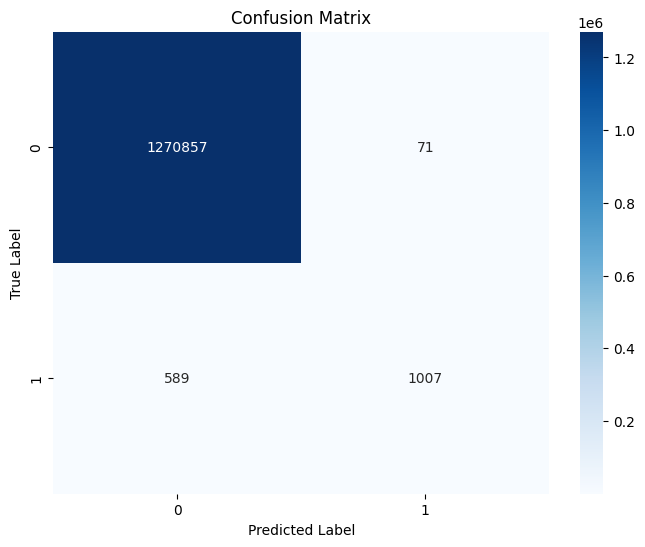

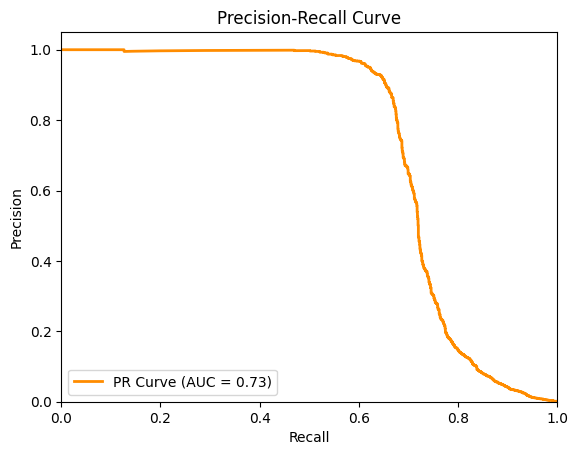

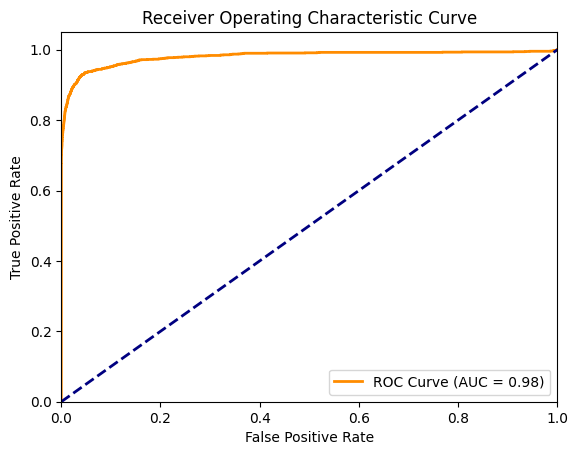

Error on training set: 0.0011005896
Error on cross-validation set: 0.001151702


In [36]:
# prompt: plot confusion matrix, pr curve, roc curve and find the errors on train and test set from the model

from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sb

# Calculate the confusion matrix
cm = confusion_matrix(y_cv, y_pred_xgb)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sb.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Calculate the precision-recall curve
precision, recall, _ = precision_recall_curve(y_cv, preds)

# Calculate the PR AUC
pr_auc = auc(recall, precision)

# Plot the PR curve
plt.figure()
lw = 2
plt.plot(recall, precision, color="darkorange", lw=lw, label="PR Curve (AUC = %0.2f)" % pr_auc)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_cv, preds)

# Calculate the ROC AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color="darkorange", lw=lw, label="ROC Curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right")
plt.show()

# Calculate the error on the train and test sets
error_train = np.mean(np.abs(y_train - model.predict(dtrain_reg)))
error_cv = np.mean(np.abs(y_cv - model.predict(dcv_reg)))

# Print the errors
print("Error on training set:", error_train)
print("Error on cross-validation set:", error_cv)